<center><h1>Марков Александр</h1><h3>Нейронные сети. Лаба 4 / RBF-сети</h3></center>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def kmeans(X, k):
    """Performs k-means clustering for 1D input
    
    Arguments:
        X {ndarray} -- A Mx1 array of inputs
        k {int} -- Number of clusters
    
    Returns:
        ndarray -- A kx1 array of final cluster centers
    """
 
    # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
 
    while not converged:
        """
        compute distances for each cluster center to each point 
        where (distances[i, j] represents the distance between the ith point and jth cluster)
        """
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
 
        # find the cluster that's closest to each point
        closestCluster = np.argmin(distances, axis=1)
 
        # update clusters by taking the mean of all of the points assigned to that cluster
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
 
        # converge if clusters haven't moved
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
 
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
 
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            # keep track of clusters with no points or 1 point
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 
    # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
 
    return clusters, stds

**Задание:**
```
a = 0.3; b = 0.3; alpha = 0, x_0 = 0, y_0 = 0
a = 0.7; b = 0.7; alpha = 0, x_0 = 0, y_0 = 0
a = 1.0; b = 1.0; alpha = 0, x_0 = 0, y_0 = 0
```

**Напишем функцию генерации точек эллипсов по их параметрам**

In [3]:
generate_ellipse = lambda a, b, alpha: (a * torch.cos(alpha), b * torch.sin(alpha))
alpha = torch.linspace(0, 360, 300)

**Построим эллипсы, что даны в задании**

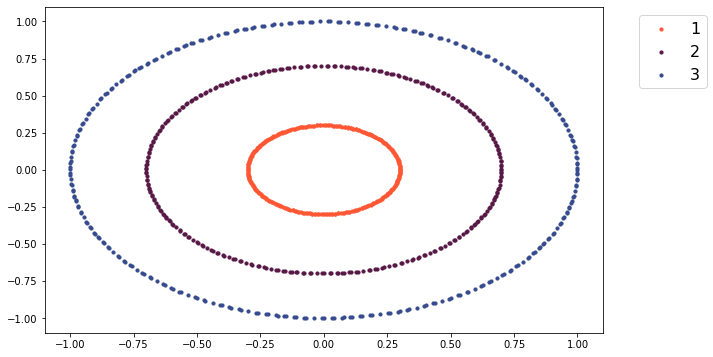

In [4]:
plt.figure(figsize=(10, 6))

plt.scatter(*generate_ellipse(0.3, 0.3, alpha), s=10, c="#ff5733", label="1")
plt.scatter(*generate_ellipse(0.7, 0.7, alpha), s=10, c="#581845", label="2")
plt.scatter(*generate_ellipse(1.0, 1.0, alpha), s=10, c="#364b8d", label="3")

plt.legend(prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left')

**Теперь реализуем RBF (в качестве функции будем использовать Гаусса без константы)**

$$ \phi(x, c_j) = \exp{ \frac{-||x-c_j||^2}{2 \sigma_j^2} } $$

In [5]:
rbf = lambda x, center, s: np.exp(-(x - center)**2 / (2 * s**2))

**Будем использовать квадратичную функцию для минимизации ошибки при обучении**

$$loss = \Sigma_{i=1}^N [y^{(i)} - F(x^{(i)})]^2$$

In [6]:
loss = nn.MSELoss(reduction="sum")

**Напишем класс нашей сети**

In [7]:
class RBFNet(nn.Module):
    def __init__(self, class_num=2, rbf=rbf):
        super().__init__()
        self.class_num = class_num
        self.rbf = rbf
        self.w = np.random.rand(class_num)
        self.b = np.random.rand(1)
        
    def fit(self, X, y):
        self.centers, _ = kmeans(X, self.class_num)
        dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.stds = np.repeat(dMax / np.sqrt(2*self.class_num), self.class_num)
        
        return
 
        # training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                # forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) # + self.b

                loss = (y[i] - F).flatten() ** 2
                print('Loss: {0:.2f}'.format(loss[0]))

                # backward pass
                error = -(y[i] - F).flatten()

                # online update
                self.w = self.w - self.lr * a * error
#                 self.b = self.b - self.lr * error
                
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) # + self.b
            y_pred.append(F)
        return np.array(y_pred)

In [8]:
x, y = generate_ellipse(0.3, 0.3, alpha)

In [9]:
model = RBFNet()
model.fit(x[::2].unsqueeze(1).numpy(), y[::2].unsqueeze(1).numpy())

In [10]:
y_pred = model.predict(x[::3].unsqueeze(1).numpy())

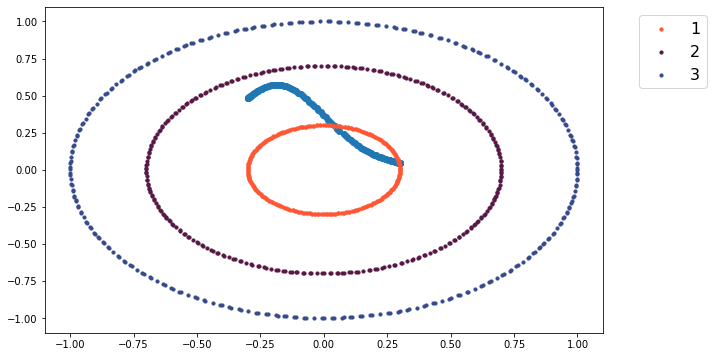

In [11]:
plt.figure(figsize=(10, 6))

plt.scatter(x[::3].unsqueeze(1).numpy(), y_pred)

plt.scatter(*generate_ellipse(0.3, 0.3, alpha), s=10, c="#ff5733", label="1")
plt.scatter(*generate_ellipse(0.7, 0.7, alpha), s=10, c="#581845", label="2")
plt.scatter(*generate_ellipse(1.0, 1.0, alpha), s=10, c="#364b8d", label="3")

plt.legend(prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left')